## Spatial ICA

Technical: https://www.cs.jhu.edu/~ayuille/courses/Stat161-261-Spring14/HyvO00-icatut.pdf, https://arxiv.org/pdf/1404.2986.pdf
Carsten: https://github.com/akcarsten/Independent_Component_Analysis

### Step 1: Import Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import FastICA
import pandas as pd
from IPython.display import HTML
from scipy.linalg import eigh, sqrtm
from sklearn.preprocessing import StandardScaler

def print_color(text, color="black", font_weight="normal", font_style="normal", font_size="small"): 
    display(HTML(f'<span style="color: {color};font-weight: {font_weight}; font-style: {font_style}; font-size: {font_size};">{text}</span>'))

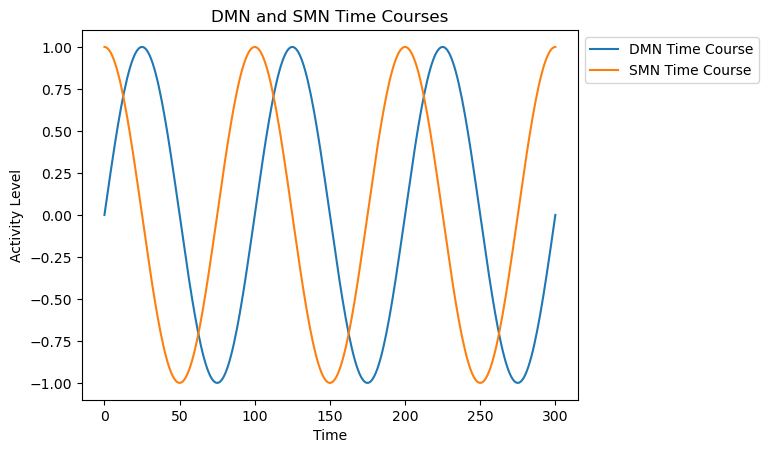

In [2]:
# Number of time points
n_timepoints = 300

# Time vector
time = np.linspace(0, 300, n_timepoints)

# Simulate time courses for two networks
dmn_timecourse = np.sin(0.02 * np.pi * time)
smn_timecourse = np.cos(0.02 * np.pi * time)

# Plotting both time courses in the same plot
plt.figure()
plt.plot(time, dmn_timecourse, label='DMN Time Course')
plt.plot(time, smn_timecourse, label='SMN Time Course')
plt.xlabel('Time')
plt.ylabel('Activity Level')
plt.title('DMN and SMN Time Courses')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

### Step 3: Create Spatial Maps (Resting-State Networks)

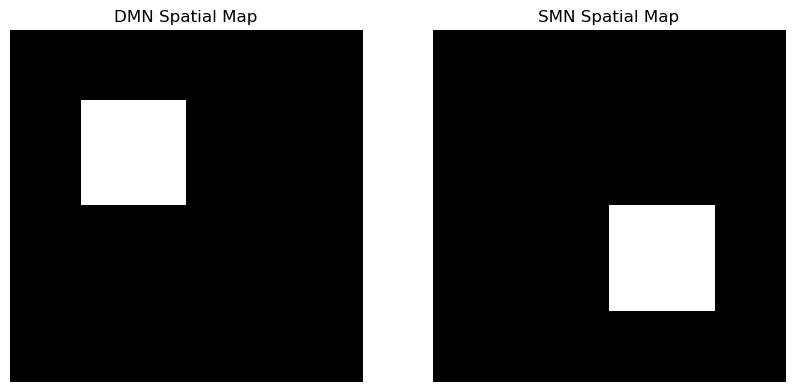

In [3]:
# Spatial dimensions (let's say it's a 10x10 image)
x_dim, y_dim = 10, 10

# Initialize spatial maps as zeros
dmn_spatial = np.zeros((x_dim, y_dim))
smn_spatial = np.zeros((x_dim, y_dim))

# Make some regions active in each spatial map
dmn_spatial[2:5, 2:5] = 1
smn_spatial[5:8, 5:8] = 1

# Create a figure
plt.figure(figsize=(10, 5))

# Plot DMN spatial map
plt.subplot(1, 2, 1)
plt.imshow(dmn_spatial, cmap='gray')
plt.title('DMN Spatial Map')
plt.axis('off')

# Plot SMN spatial map
plt.subplot(1, 2, 2)
plt.imshow(smn_spatial, cmap='gray')
plt.title('SMN Spatial Map')
plt.axis('off')

# Show the figure
plt.show()

### Step 4: Generate Synthetic 4D fMRI Data

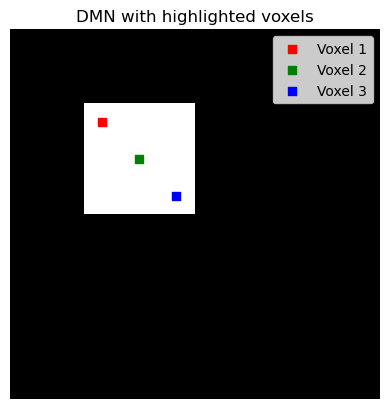

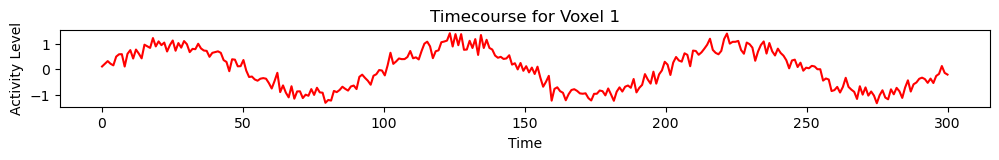

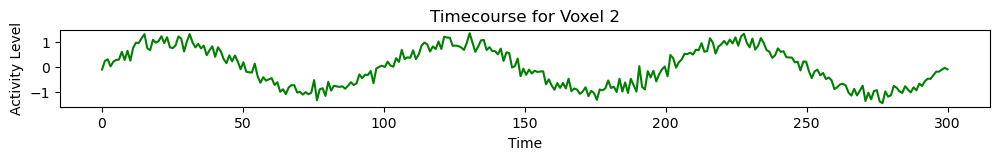

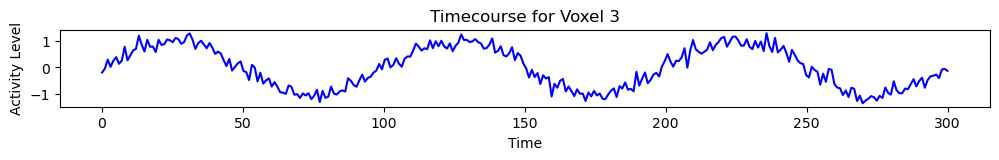

In [4]:
# Initialize the 4D fMRI data array
fmri_data = np.zeros((x_dim, y_dim, n_timepoints))

# Generate synthetic fMRI data
for t in range(n_timepoints):
    fmri_data[:, :, t] = dmn_spatial * dmn_timecourse[t] + smn_spatial * smn_timecourse[t]

# Add some Gaussian noise
fmri_data += 0.2 * np.random.normal(size=fmri_data.shape)

# Choose 3 voxels in the DMN (let's say (2, 2), (3, 3), and (4, 4))
voxel_coords = [(2, 2), (3, 3), (4, 4)]
colors = ['red', 'green', 'blue']

# Plot DMN with highlighted voxels
plt.figure()
plt.imshow(dmn_spatial, cmap='gray')
for i, (x, y) in enumerate(voxel_coords):
    plt.scatter(y, x, color=colors[i], label=f'Voxel {i+1}', marker='s')
plt.title('DMN with highlighted voxels')
plt.legend()
plt.axis('off')
plt.show()

# Plot timecourses for each selected voxel
for i, (x, y) in enumerate(voxel_coords):
    plt.figure(figsize=(12,1))
    plt.plot(time, fmri_data[x, y, :], color=colors[i])
    plt.title(f'Timecourse for Voxel {i+1}')
    plt.xlabel('Time')
    plt.ylabel('Activity Level')
    plt.show()

### Step 5: Perform Spatial ICA to Recover Networks
1. Preprocess the data: centering and whitening
2. Implement the ICA algorithm: optimization of non-Gaussianity (or FastICA)
3. Extract the independent components

**Whitening:** Makes the data zero mean and scales it to have a unit covariance matrix.

**Initialization:** We initialize random weights for as many components as we want to find.

**Iteration:** We update the weights by maximizing non-Gaussianity (here approximated by a function of the independent components).

**Independent Components:** The final spatial maps are reshaped to the original shape (x_dim, y_dim, num_components).

In [5]:
# Reshape the 4D data into 2D data (voxels x time)
data_reshaped = fmri_data.reshape(-1, n_timepoints).T
print(f"fmri_data before reshaping: {fmri_data.shape}")
print(f"fmri_data after reshaping: {data_reshaped.shape}\n")
#print_color("ROWS = voxels, COLS = timepoints", color="black", font_weight="bold")
#display(pd.DataFrame(X))

# Zero-mean the data
data_reshaped -= np.mean(data_reshaped, axis=0)

# Step 3: Calculate covariance matrix
cov_matrix = np.cov(data_reshaped, rowvar=True)

# Step 4: Perform Eigenvalue Decomposition
eigenvalues, eigenvectors = np.linalg.eigh(cov_matrix)
idx = eigenvalues.argsort()[::-1]
eigenvalues = eigenvalues[idx]
eigenvectors = eigenvectors[:, idx]

# Step 5: Whiten the data using only top-k components
num_components = 3
top_eigenvectors = eigenvectors[:, :num_components]
whitening_matrix = np.dot(top_eigenvectors, np.diag(1.0 / np.sqrt(eigenvalues[:num_components])))
whitened_data = np.dot(whitening_matrix.T, data_reshaped)

# Step 6: Perform ICA optimizing for non-Gaussianity
np.random.seed(0)
W = np.random.rand(num_components, num_components)

for i in range(1000):
    projected_data = np.dot(W, whitened_data)
    kurtosis = np.mean(projected_data ** 4, axis=1) - 3
    W_new = np.dot((projected_data ** 3), whitened_data.T) / num_components - 3 * W
    W_new = np.linalg.qr(W_new)[0]
    
    # Check for convergence
    convergence_threshold = 1e-6
    if np.allclose(W, W_new, atol=convergence_threshold):
        print(f"Converged at iteration {i}")
        break

    W = W_new

s_ica = np.dot(W, whitened_data)
ica_maps = s_ica.T.reshape(fmri_data.shape[0], fmri_data.shape[1], num_components)

# Reshape the independent components to have the same shape as the original spatial maps
print("ICA Maps shape:", ica_maps.shape)


### FastICA
# # Initialize and fit FastICA
# ica = FastICA(n_components=2)
# S_ica = ica.fit_transform(X)

# # Reshape the independent components to have the same shape as the original spatial maps
# ica_maps = S_ica.reshape(x_dim, y_dim, 2)


fmri_data before reshaping: (10, 10, 300)
fmri_data after reshaping: (300, 100)

Converged at iteration 12
ICA Maps shape: (10, 10, 3)


### Step 6: Visualize Results

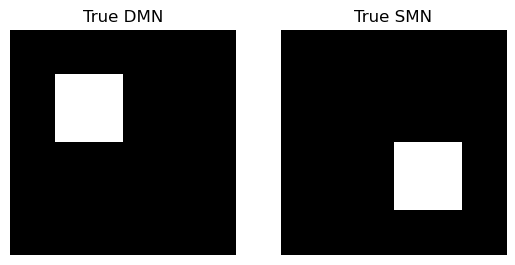

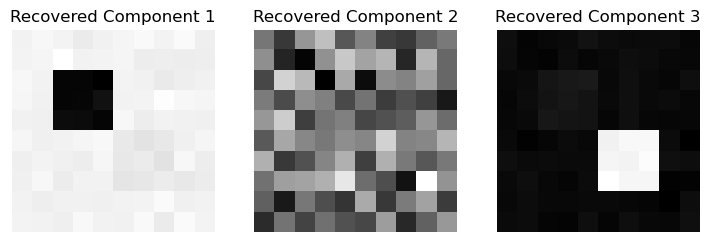

In [10]:
# Plot the true spatial maps
plt.figure()
plt.subplot(1, 2, 1)
plt.title("True DMN")
plt.imshow(dmn_spatial, cmap='gray')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("True SMN")
plt.imshow(smn_spatial, cmap='gray')
plt.axis('off')

# plt.show()
n_plots = ica_maps.shape[2]
n_rows = int(np.ceil(n_plots / 4.0))
plt.figure(figsize=(12, 8))
for i in range(n_plots):
    plt.subplot(n_rows, 4, i + 1)
    plt.title(f"Recovered Component {i + 1}")
    plt.imshow(ica_maps[:, :, i], cmap='gray')
    plt.axis('off')

## Difference between PCA and ICA

ICA:
1. Center x by subtracting the mean
2. Whiten x
3. Choose a random initial value for the de-mixing matrix w
4. Calculate the new value for w
5. Normalize w
6. Check whether algorithm has converged and if it hasn’t, return to step 4
7. Take the dot product of w and x to get the independent source signals

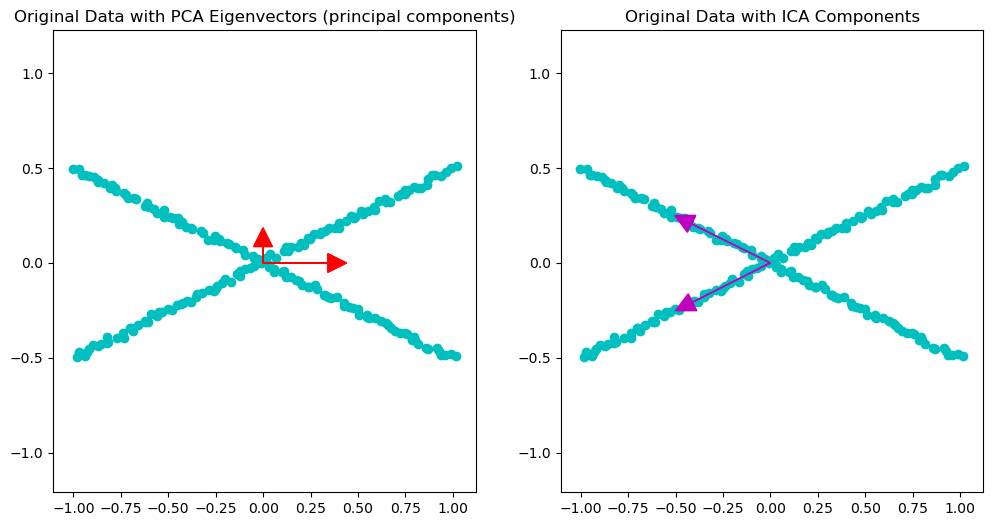

In [67]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA, FastICA

# Generate synthetic data forming an 'X'
np.random.seed(0)
n_points = 100
line = np.linspace(-1, 1, n_points)
slope = 0.5  # smaller slope for a tighter X
noise_scale = 0.01

# Create lines and add some noise
X1 = np.column_stack((line, slope * line)) + noise_scale * np.random.randn(n_points, 2)
X2 = np.column_stack((line, -slope * line)) + noise_scale * np.random.randn(n_points, 2)
X = np.vstack((X1, X2))

# Perform PCA
pca = PCA()
pca.fit(X)
eigenvectors = pca.components_
eigenvalues = pca.explained_variance_

# Perform ICA
ica = FastICA(n_components=2, random_state=0)
ica.fit(X)
ica_components = ica.mixing_

# Plot original data with PCA components
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.scatter(X[:, 0], X[:, 1], c='c')
plt.title('Original Data with PCA Eigenvectors (principal components)')
plt.axis('equal')
origin = np.mean(X, axis=0)
for i in range(len(eigenvectors)):
    plt.arrow(origin[0], origin[1], eigenvectors[i, 0] * eigenvalues[i], eigenvectors[i, 1] * eigenvalues[i],
              head_width=0.1, head_length=0.1, fc='r', ec='r')

# Plot original data with ICA components
plt.subplot(1, 2, 2)
plt.scatter(X[:, 0], X[:, 1], c='c')
plt.title('Original Data with ICA Components')
plt.axis('equal')
for i in range(ica_components.shape[1]):
    plt.arrow(origin[0], origin[1], ica_components[0, i], ica_components[1, i],
              head_width=0.1, head_length=0.1, fc='m', ec='m')

plt.show()

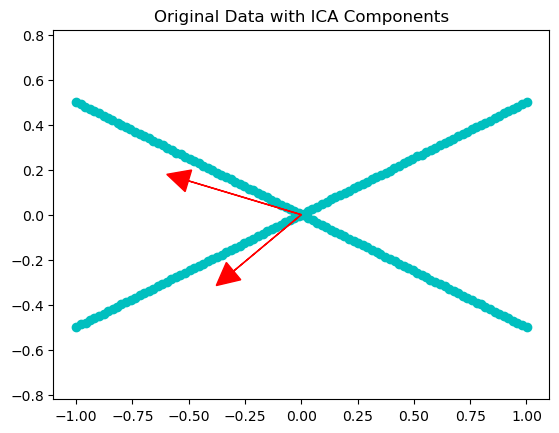

In [72]:
import numpy as np
import matplotlib.pyplot as plt

# Generate synthetic data forming an 'X'
np.random.seed(0)
n_points = 100
line = np.linspace(-1, 1, n_points)
slope = 0.5

# Create lines and add some noise
X1 = np.column_stack((line, slope * line)) + 0.001 * np.random.randn(n_points, 2)
X2 = np.column_stack((line, -slope * line)) + 0.001 * np.random.randn(n_points, 2)
X = np.vstack((X1, X2))

# Center the data
X_centered = X - np.mean(X, axis=0)

# Whiten the data
cov_matrix = np.cov(X_centered.T)
eigenvalues, eigenvectors = np.linalg.eig(cov_matrix)
X_whitened = X_centered.dot(eigenvectors).dot(np.diag(1.0 / np.sqrt(eigenvalues)))

# Number of components to find
num_components = 2

W = np.zeros((2, num_components))

for i in range(num_components):
    w = np.random.rand(2)
    for _ in range(10000):
        w_new = np.mean((X_whitened ** 3) * w[i], axis=0) - 3 * w
        w_new /= np.linalg.norm(w_new)
        
        # Make the new vector orthogonal to the existing ones
        for j in range(i):
            w_new -= w_new.dot(W[:, j]) * W[:, j]
            
        w_new /= np.linalg.norm(w_new)

        # Check for convergence
        if np.abs(np.abs((w_new * w).sum()) - 1) < 1e-5:
            break
        w = w_new
    W[:, i] = w

# Transform the ICA components back to the original space
ica_components = np.linalg.inv(eigenvectors.dot(np.diag(1.0 / np.sqrt(eigenvalues)))).T.dot(W)

# Plot original data with ICA components
plt.scatter(X[:, 0], X[:, 1], c='c')
plt.title('Original Data with ICA Components')
plt.axis('equal')

origin = np.mean(X, axis=0)

for i in range(ica_components.shape[1]):
    plt.arrow(origin[0], origin[1], ica_components[0, i], ica_components[1, i],
              head_width=0.1, head_length=0.1, fc='r', ec='r')

plt.show()


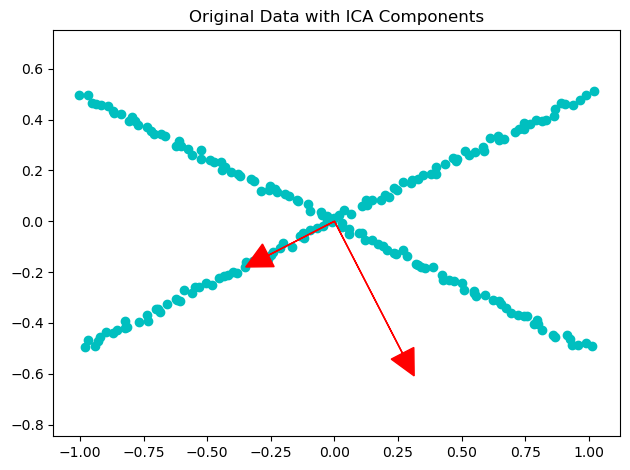

In [79]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import FastICA

def myFastICA(X, n_components=2, random_state=0, max_iter=200, tolerance=1e-4):
    np.random.seed(random_state)
    
    # Center the data
    X_mean = np.mean(X, axis=0)
    X_centered = X - X_mean
    
    # Whiten the data
    cov_matrix = np.cov(X_centered.T)
    eigenvalues, eigenvectors = np.linalg.eigh(cov_matrix)
    X_whitened = X_centered.dot(eigenvectors).dot(np.diag(1 / np.sqrt(eigenvalues)))
    
    # Initialize unmixing matrix W
    W = np.random.rand(n_components, n_components)
    
    # Update W using FastICA
    for i in range(max_iter):
        W_new = np.dot(X_whitened.T, np.tanh(np.dot(X_whitened, W))) - np.sum(1 - np.tanh(np.dot(X_whitened, W)) ** 2, axis=0)[:, None] * W
        W_new = W_new / np.sqrt((W_new ** 2).sum(axis=0))[None, :]
        
        # Orthogonalize the new estimate for W
        W_new = np.linalg.qr(W_new)[0]
        
        # Check convergence
        if np.all(np.abs(np.abs(np.diag(np.dot(W_new, W.T))) - 1) < tolerance):
            break
            
        W = W_new
    
    # Compute the independent components
    S_ = np.dot(X_whitened, W.T)
    
    # Compute the mixing matrix
    A_ = np.linalg.pinv(W).dot(eigenvectors.T).dot(np.diag(np.sqrt(eigenvalues)))
    
    return S_, A_

# Generate synthetic data
np.random.seed(0)
n_points = 100
line = np.linspace(-1, 1, n_points)
slope = 0.5
noise_scale = 0.01
X1 = np.column_stack((line, slope * line)) + noise_scale * np.random.randn(n_points, 2)
X2 = np.column_stack((line, -slope * line)) + noise_scale * np.random.randn(n_points, 2)
X = np.vstack((X1, X2))

# Apply FastICA
# ica = FastICA(n_components=2, random_state=0)
# S_ = ica.fit_transform(X)
# A_ = ica.mixing_

# Apply myFastICA
S_, A_ = myFastICA(X, n_components=2, random_state=0)

# Plotting
plt.figure()

plt.subplot(1, 1, 1)
plt.title('Original Data with ICA Components')
plt.scatter(X[:, 0], X[:, 1], c='c')

for vec in A_.T:
    plt.arrow(0, 0, vec[0], vec[1], head_width=0.1, head_length=0.1, fc='r', ec='r')

plt.axis('equal')
plt.tight_layout()
plt.show()


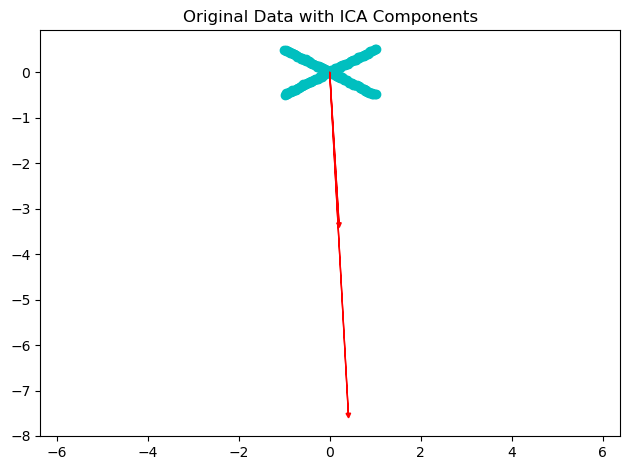

In [83]:
import numpy as np
import matplotlib.pyplot as plt

def myFastICA(X, n_components=2, random_state=None, max_iter=200, tol=1e-4):
    np.random.seed(random_state)
    
    # Center the data
    X_mean = np.mean(X, axis=0)
    X_centered = X - X_mean
    
    # Whiten the data
    cov_matrix = np.cov(X_centered, rowvar=False)
    eig_vals, eig_vecs = np.linalg.eigh(cov_matrix)
    X_whitened = np.dot(X_centered, eig_vecs) / np.sqrt(eig_vals)
    
    # Initialize W
    W = np.random.normal(size=(n_components, n_components))
    
    # Optimize W
    for iteration in range(max_iter):
        wx = np.dot(W, X_whitened.T)
        gwx = np.tanh(wx)
        g_wx = 1 - gwx ** 2
        
        # Update W1
        W1 = np.dot(gwx, X_whitened) / X.shape[0] - np.multiply(g_wx.mean(axis=1)[:, np.newaxis], W)
        
        # Decorrelate outputs
        W1 = np.dot(W1, np.linalg.inv(np.sqrt(np.linalg.eig(np.dot(W1.T, W1))[0]) * np.eye(W1.shape[1])))
        
        # Check for convergence
        lim = max(abs(abs(np.diag(np.dot(W1, W.T))) - 1))
        if lim < tol:
            break
        W = W1
    
    # Compute the independent components and mixing matrix
    S_ = np.dot(W, X_whitened.T).T
    A_ = np.linalg.pinv(W).dot(eig_vecs.T).dot(np.diag(np.sqrt(eig_vals)))
    
    return S_, A_

# Generate synthetic data
np.random.seed(0)
n_points = 100
line = np.linspace(-1, 1, n_points)
slope = 0.5
noise_scale = 0.01
X1 = np.column_stack((line, slope * line)) + noise_scale * np.random.randn(n_points, 2)
X2 = np.column_stack((line, -slope * line)) + noise_scale * np.random.randn(n_points, 2)
X = np.vstack((X1, X2))

# Apply myFastICA
S_, A_ = myFastICA(X, n_components=2, random_state=0)

# Plotting
plt.figure()
plt.title('Original Data with ICA Components')
plt.scatter(X[:, 0], X[:, 1], c='c')

for vec in A_.T:
    plt.arrow(0, 0, vec[0], vec[1], head_width=0.1, head_length=0.1, fc='r', ec='r')

plt.axis('equal')
plt.tight_layout()
plt.show()
